# Burmese Poem Classification - Deep Learning Only

A deep learning pipeline for classifying Burmese poems into traditional types using LSTM, CNN, and Transformer models.

## Features:
- Custom Burmese text preprocessing with syllable splitting
- Deep learning models (LSTM, CNN, Transformer)
- Character-level tokenization for Burmese text
- Production-ready classifier with confidence scoring


My pipeline for Burmese Poem Classification using Deep Learning is the following:
    1. Extract data from poem books with ocr
    2. Extract poem with Gemini 
    3. Edit poem manually with poem_editor.
    4. train the model between 3 class . modern poem, traditional poem,traditional song
    5. if traditional poem 
                - grap its rhyme schme,line number,stanza
                - compare it with rule based library
                - give output , happy :3

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import re
import os
import glob
from pathlib import Path
import warnings
import time
from collections import Counter

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Embedding, Dropout, Conv1D, 
                                    GlobalMaxPooling1D, Bidirectional, MultiHeadAttention, 
                                    LayerNormalization, Add, GlobalAveragePooling1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')
print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
# ==============================================================================
def custom_syllable_splitter(text: str) -> list:
    """
    Performs a deep syllable split by breaking down all consonant stacks.
    This function uses a two-step process to achieve the required logic for
    cases like 'နက္ခတ္တ' and 'ဥက္ကဋ္ဌ'.
    """

    
    # --- Step 1: Pre-processing to split stacks using a loop ---
    # This loop is the only reliable way to handle chained stacks.
    stacked_consonant_pattern = r'([က-အ])(်?္)([က-အ])'
    processed_text = text
    while re.search(stacked_consonant_pattern, processed_text):
        processed_text = re.sub(stacked_consonant_pattern, r'\1်'  + r'\3', processed_text)
    processed_text = re.sub(r"(([A-Za-z0-9]+)|[က-အ|ဥ|ဦ](င်္|[က-အ|ဥ][ှ]*[့း]*[်]|္[က-အ]|[ါ-ှႏꩻ][ꩻ]*){0,}|.)",r"\1 ", processed_text)
    print()
   #Step 2: Tokenization of the processed parts ---
   # The string is now clean of stacks, so we can tokenize it reliably.
    final_list = processed_text.split(" ")
    
    # Filter out empty strings caused by trailing spaces
    final_list = [word for word in final_list if word.strip()]
        
    return final_list

# Data Loading and Preprocessing Functions

In [3]:
# Data Loading Functions

def load_excel_data(file_path='Poem Excel files.xlsx'):
    """Load and process data from Excel file"""
    print("Loading Excel data...")
    
    try:
        df = pd.read_excel(file_path)
        print(f"Excel data shape: {df.shape}")
        print(f"Poem types (columns): {list(df.columns)}")
        
        # Reshape data from wide to long format
        excel_poems = []
        
        for col in df.columns:
            for idx, row in df.iterrows():
                poem_text = row[col]
                if pd.notna(poem_text) and str(poem_text).strip():
                    excel_poems.append({
                        'title': f'Excel_Poem_{idx}_{col}',
                        'author': 'Unknown',
                        'poem_lines': [str(poem_text)],
                        'poem_type': col,
                        'source': 'excel',
                        'notes': f'Row {idx}'
                    })
        
        print(f"Extracted {len(excel_poems)} poems from Excel")
        return excel_poems
    
    except FileNotFoundError:
        print(f"Excel file {file_path} not found. Skipping Excel data.")
        return []

def load_json_data(json_dir='PoemJsonFiles'):
    """Load and process data from JSON files"""
    print("Loading JSON data...")
    
    json_poems = []
    
    if os.path.exists(json_dir):
        json_files = glob.glob(os.path.join(json_dir, '*.json'))
        print(f"Found {len(json_files)} JSON files")
        
        for json_file in json_files:
            try:
                with open(json_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                # Handle both single poem and list of poems
                if isinstance(data, dict):
                    data = [data]
                
                for poem in data:
                    if 'poem_lines' in poem and 'poem_type' in poem:
                        poem['source'] = 'json'
                        json_poems.append(poem)
                        
            except Exception as e:
                print(f"Error loading {json_file}: {e}")
    else:
        print(f"JSON directory {json_dir} not found or empty")
    
    print(f"Extracted {len(json_poems)} poems from JSON files")
    return json_poems


print("✅ Data loading functions defined!")




✅ Data loading functions defined!


လင်္ကာမှာ (၁) လင်္ကာ၊ (၂) ပျို့၊ (၃) မော်ကွန်း၊ (၄) သံပိုင်း၊ (၅) သမိုင်း၊ (၆) ရဲတင်း၊ (၇) တမ်းချင်း၊ (၈) ဧချင်းသံတိုင်၊ (၉) ဧချင်းသံပေါက်၊ (၁၀) ရတု၊ (၁၁) လူးတား၊ (၁၂) အန်၊ (၁၃) သံပေါက်၊ (၁၄) ဝဲရိုက်ဝဲသွင်းဟူ၍ ၁၄ မျိုး ရှိ၏။ 

သီချင်းတွင် (၁) ရကန်၊ (၂) ဟောစာ၊ (၃) သာချင်း၊ (၄) ကာချင်း၊(၅) အဲချင်း၊ (၆) အိုင်ချင်း၊ (၇) လေးချိုး၊ (၈) သံချို၊ (၉) ယိုးဒယား၊ (၁၀) ပတ်ပျိုး၊ (၁၁) ကြိုး၊ (၁၂) ဘွဲ့၊ (၁၃) ဘောလယ်အရိုး၊(၁၄) တေးအရိုးအဆန်း၊ (၁၅) သဖြန်အရိုးအဆန်း၊ (၁၆) ငိုချင်းအရိုးအဆန်း၊ (၁၇) တုံးချင်း အရိုးအဆန်း၊ (၁၈) ဟန်ချင်း အရိုး အဆန်း၊ (၁၉) လှေချင်း အရိုးအဆန်း၊(၂၀) နတ်သံ၊ (၂၁) မှာတမ်း၊ (၂၂) ဇာတ်စကားစပ်ပုံဟူ၍ ၂၂ မျိုးပါဝင်သည်။

In [4]:
def harmonize_poem_types():
    """
    Creates a mapping to consolidate various Burmese poem types
    into a smaller, more consistent set of categories.
    """
    poem_type_mapping = {
        # --- Modern Poetry (ခေတ်ပေါ်ကဗျာ) ---
        # This category includes modern, free-form, and translated poetry.
        'ခေတ်ပေါ်ကဗျာ': 'ခေတ်ပေါ်ကဗျာ',
        'ရင်ဖွင့်ကဗျာ': 'ခေတ်ပေါ်ကဗျာ',
        'ခေတ်စမ်းကဗျာ': 'ခေတ်ပေါ်ကဗျာ',
        'Modern Burmese Poetry': 'ခေတ်ပေါ်ကဗျာ',
        'ကဗျာတို': 'ခေတ်ပေါ်ကဗျာ',
        'ကဗျာ': 'ခေတ်ပေါ်ကဗျာ',
        'Prose Poem': 'ခေတ်ပေါ်ကဗျာ',
        'Translation': 'ခေတ်ပေါ်ကဗျာ',
        'ခေတ်စမ်းလင်္ကာ': 'ခေတ်ပေါ်ကဗျာ',
        'တေးထပ်ညှပ် ဒွေးချိုးဆက်': 'ခေတ်ပေါ်ကဗျာ',
        'လွတ်လပ်ကာရန်': 'ခေတ်ပေါ်ကဗျာ',
        'လေးချိုးသဖြန်': 'ခေတ်ပေါ်ကဗျာ',
        'ဘာသာပြန်ကဗျာ': 'ခေတ်ပေါ်ကဗျာ',
        'Prose': 'ခေတ်ပေါ်ကဗျာ',
        'Long-form Poem': 'ခေတ်ပေါ်ကဗျာ',
        
        # --- Classical Poetic Forms (လင်္ကာ) ---
        # These are traditional poetic types with specific metrical rules.
        'တေးကဗျာ': 'လင်္ကာ',
        'လေးချိုး': 'လင်္ကာ',
        'ဒွေးချိုး': 'လင်္ကာ',
        'တောလား': 'လင်္ကာ',
        'တြိချိုး': 'လင်္ကာ',
        'ကလေးကဗျာ': 'လင်္ကာ',
        'ရတု': 'လင်္ကာ',
        'သံပေါက်': 'လင်္ကာ',
        'ကဗျာရှည်': 'လင်္ကာ',
        'ရတနာကြုတ်သွား': 'လင်္ကာ',
        'ပျို့': 'လင်္ကာ',
        'လူးတား': 'လင်္ကာ',
        'အကျင့်ဝတ်ကဗျာ': 'လင်္ကာ',
        'စာထောင့်လေးချိုး': 'လင်္ကာ',
        'လေးချိုးကြီး': 'လင်္ကာ',
        'ရတနာကြုတ်သွား (ကိုးလုံးဖွဲ့)': 'လင်္ကာ',
        'လေးလုံးစပ်': 'လင်္ကာ',
        'လေးဆစ်ချိုး': 'လင်္ကာ',
        'လေးဆစ်': 'လင်္ကာ',
        '၃-ဆစ်ချိုး': 'လင်္ကာ',
        '၃ ကြော့': 'လင်္ကာ',
        'ပိုဒ်စုံရတု': 'လင်္ကာ',
        'Haiku': 'လင်္ကာ',
        'နိဂုံးလင်္ကာ': 'လင်္ကာ',
        
        # --- Songs & Melodic Forms (သီချင်း) ---
        # These are poem types intended to be sung or chanted.
        'ကြိုးသီချင်း': 'သီချင်း',
        'လွမ်းချင်း': 'သီချင်း',
        'ဒုံးချင်း': 'သီချင်း',
        'တမ်းချင်း': 'သီချင်း',
        'တျာချင်း': 'သီချင်း',
        'အိုင်ချင်း': 'သီချင်း',
        'ညည်းချင်း': 'သီချင်း',
        'ဘောလယ်': 'သီချင်း',
        'သဖြန်': 'သီချင်း',
        'အဲချင်း': 'သီချင်း',
        'ကာချင်း': 'သီချင်း',
        'ခွန်းထောက်': 'သီချင်း',
        'ဟန်ချင်း': 'သီချင်း',
        'မျိုးစောင့်တေး': 'သီချင်း',
        'ပတ်ပျိုး': 'သီချင်း',
        'ရကန်': 'သီချင်း',
        'သံချို': 'သီချင်း',
        'အန်ချင်း': 'သီချင်း',
        'သံချိုလေးချိုး': 'သီချင်း',
        'တိုက်ပွဲမှတ်တမ်းသီချင်း': 'သီချင်း',
        'တပ်ထွက်သီချင်း': 'သီချင်း',
        'သူရဲကောင်းသီချင်း': 'သီချင်း',
        'အောင်ပွဲသီချင်း': 'သီချင်း',
        'ဇာတိမာန်သီချင်း': 'သီချင်း',
        'ငိုချင်း': 'သီချင်း',
        'အလွမ်းသီချင်း': 'သီချင်း',
        
    
        'တေးထပ်': 'သီချင်း',
        'ပိဋကသွား': None,
        'အမှာ': None,
        
        # --- Unrecognized/Error Values ---
        # This seems to be an invalid entry from the source data.
        None: None,
    }
    
    return poem_type_mapping

In [5]:
# FIXED: Show Examples of Each Poem Type (handles None values)

def show_poem_examples_fixed(use_harmonized=True, max_lines=5):
    """
    FIXED VERSION: Show actual examples of each poem type from the dataset
    Now handles None values properly
    
    Args:
        use_harmonized (bool): Use harmonized poem types or original types
        max_lines (int): Maximum number of lines to show per poem
    """
    print("📚 POEM TYPE EXAMPLES (FIXED VERSION)")
    print("=" * 60)
    
    # Load all data
    all_poems = load_excel_data() + load_json_data()
    
    if not all_poems:
        print("❌ No poems found!")
        return
    
    # Get type mapping if using harmonized types
    type_mapping = harmonize_poem_types() if use_harmonized else {}
    
    # Group poems by type (handle None values)
    poems_by_type = {}
    for poem in all_poems:
        original_type = poem.get('poem_type', 'Unknown')
        
        # Handle None values
        if original_type is None:
            original_type = 'Unknown'
        
        poem_type = type_mapping.get(original_type, original_type) if use_harmonized else original_type
        
        # Ensure poem_type is not None
        if poem_type is None:
            poem_type = 'Unknown'
        
        if poem_type not in poems_by_type:
            poems_by_type[poem_type] = []
        poems_by_type[poem_type].append(poem)
    
    # Show examples for each type
    type_label = "HARMONIZED" if use_harmonized else "ORIGINAL"
    print(f"Showing examples from {len(poems_by_type)} {type_label} poem types:\n")
    
    for poem_type, poems in sorted(poems_by_type.items(), key=lambda x: len(x[1]), reverse=True):
        # Safe handling of poem_type (should not be None now, but extra safety)
        display_type = str(poem_type).upper() if poem_type else "UNKNOWN"
        print(f"🎭 {display_type} ({len(poems)} poems)")
        print("-" * 40)
        
        # Show first poem as example
        example_poem = poems[0]
        title = example_poem.get('title', 'No title') or 'No title'
        author = example_poem.get('author', 'Unknown') or 'Unknown'
        lines = example_poem.get('poem_lines', []) or []
        
        print(f"📖 Title: {title}")
        print(f"✍️  Author: {author}")
        print(f"📝 Content:")
        
        if isinstance(lines, list) and lines:
            for i, line in enumerate(lines[:max_lines]):
                if line and str(line).strip():
                    print(f"   {str(line).strip()}")
            if len(lines) > max_lines:
                print(f"   ... ({len(lines) - max_lines} more lines)")
        else:
            content = str(lines)[:300] if lines else "No content"
            print(f"   {content}")
            if len(str(lines)) > 300:
                print("   ...")
        
        original_type_display = example_poem.get('poem_type', 'Unknown') or 'Unknown'
        print(f"🔢 Original type: {original_type_display}")
        print()

def show_specific_type_fixed(poem_type, use_harmonized=True, num_examples=3):
    """
    FIXED VERSION: Show multiple examples of a specific poem type
    """
    if not poem_type:
        print("❌ Please provide a poem type")
        return
        
    print(f"📚 EXAMPLES OF: {str(poem_type).upper()}")
    print("=" * 60)
    
    all_poems = load_excel_data() + load_json_data()
    type_mapping = harmonize_poem_types() if use_harmonized else {}
    
    # Find poems of specified type
    matching_poems = []
    for poem in all_poems:
        original_type = poem.get('poem_type', 'Unknown') or 'Unknown'
        current_type = type_mapping.get(original_type, original_type) if use_harmonized else original_type
        
        if current_type and str(current_type).lower() == str(poem_type).lower():
            matching_poems.append(poem)
    
    if not matching_poems:
        print(f"❌ No poems found for type: {poem_type}")
        return
    
    print(f"Found {len(matching_poems)} poems of type '{poem_type}'")
    print(f"Showing first {min(num_examples, len(matching_poems))} examples:\n")
    
    for i, poem in enumerate(matching_poems[:num_examples]):
        print(f"📖 Example {i+1}:")
        print(f"   Title: {poem.get('title', 'No title') or 'No title'}")
        print(f"   Author: {poem.get('author', 'Unknown') or 'Unknown'}")
        
        lines = poem.get('poem_lines', []) or []
        if isinstance(lines, list) and lines:
            for line in lines[:3]:
                if line and str(line).strip():
                    print(f"   {str(line).strip()}")
            if len(lines) > 3:
                print(f"   ... ({len(lines) - 3} more lines)")
        else:
            content = str(lines)[:200] if lines else "No content"
            print(f"   {content}")
            if len(str(lines)) > 200:
                print("   ...")
        print()

print("✅ FIXED poem example functions ready!")
print("💡 Usage:")
print("  show_poem_examples_fixed()  # Show one example of each type (SAFE)")
print("  show_poem_examples_fixed(use_harmonized=False)  # Show original types")
print("  show_specific_type_fixed('ခေတ်စမ်းလင်္ကာ', num_examples=5)  # Show 5 examples")


✅ FIXED poem example functions ready!
💡 Usage:
  show_poem_examples_fixed()  # Show one example of each type (SAFE)
  show_poem_examples_fixed(use_harmonized=False)  # Show original types
  show_specific_type_fixed('ခေတ်စမ်းလင်္ကာ', num_examples=5)  # Show 5 examples


In [6]:
show_poem_examples_fixed(use_harmonized=True )  # Show original types


📚 POEM TYPE EXAMPLES (FIXED VERSION)
Loading Excel data...
Excel file Poem Excel files.xlsx not found. Skipping Excel data.
Loading JSON data...
JSON directory PoemJsonFiles not found or empty
Extracted 0 poems from JSON files
❌ No poems found!


In [7]:
# Data Cleaning Functions

In [8]:
import re

def preprocess_poem_text(poem_lines, use_syllable_splitter=False):
    """Comprehensive text preprocessing for Burmese poems"""
    if isinstance(poem_lines, list):
        text = ' '.join(poem_lines)
    else:
        text = str(poem_lines)
    

    # 0. Basic cleaning: Multiple spaces to single space and strip
    text = re.sub(r'\s', '', text)
    # print(text)
    # 1. Remove newlines that follow '၊' or '။'
    text = re.sub(r'([၊။])\s*\n*+', r'\1', text)
    # print(text)
    
    # 2. Add '။' if the next line starts with a Burmese number
    text = re.sub(r'([၀-၉])', r'။ \1', text)
    # print(text)
    # remove Englsih letters and numbers and special characters
    text = re.sub(r'[A-Za-z0-9]', '', text)
    # 3. Replace any remaining newlines with a single space
    text = re.sub(r'\n+', '၊', text)
     # Replace two or more consecutive '၊' with a single '၊'
    text = re.sub(r'၊{2,}', '၊', text)
    
    # Replace two or more consecutive '။' with a single '။'
    text = re.sub(r'။{2,}', '။', text)

    text =re.sub(r'([၀-၉]+)\s*။', r'\1', text)

    text = re.sub(r'[၀-၉]+', '', text)
    text = re.sub(r'[!@#$%^&*(),.?":{}|<>~`\'\-_=+;\\/\[\]]', '', text)

        # print(text)
    text = re.sub(r'(\s|^)။', '', text)

    text = text.strip()
    
    # Note: The custom_syllable_splitter part was not included as its implementation
    # was not provided, but you can add it back if needed.
    # if use_syllable_splitter:
    #     try:
    #         syllables = custom_syllable_splitter(text)
    #         text = ' '.join(syllables)
    #     except:
    #         pass # Fallback to original text if splitter fails
    
    return text

poem_lines = [
    """    ၁။ ခိုးသားထားပြ၊ ဟူတုံက၊ မုချကြောက်အပ်စွာ
    
    ၂။ ကိုယ်တွင်းသူခိုး၊ မြင်သူခိုး၊ နှစ်မျိုးမှတ်ကြရာ။

    ၃။ ကိုယ်တွင်းထားပြ၊ ပြင်ထားပြ၊ နှစ်ဝရှိသည်သာ။

    ၄။ ကိုယ်တွင်းရန်သူ၊ ပြင်ရန်သူ၊ နှစ်မူခွဲရှုရာ။

    ၅။ ပြင်ပလူထက်၊ ကိုယ်တွင်းခက်၊ ဆက်ဆက်သိအပ်စွာ။

    ၆။ ကိုယ်တွင်းခိုးသား၊ လက်ခံထား၊ ပြင်ခိုးသားတွေ မွှေလိမ့်မည်။

    ၇။ ကိုယ်တွင်းထားပြ၊ လက်ခံကြ၊ ပြင်ကထားပြ-ချေလိမ့်မည်။

    ၈။ ကိုယ်တွင်းရန်သူ၊ လက်ခံမူ၊ ပြင်ရန်သူကြောင့်- သေလိမ့်မည်။
    """
]

processed_text = preprocess_poem_text(poem_lines=poem_lines)
print(processed_text)

ခိုးသားထားပြ၊ဟူတုံက၊မုချကြောက်အပ်စွာ။ ကိုယ်တွင်းသူခိုး၊မြင်သူခိုး၊နှစ်မျိုးမှတ်ကြရာ။ ကိုယ်တွင်းထားပြ၊ပြင်ထားပြ၊နှစ်ဝရှိသည်သာ။ ကိုယ်တွင်းရန်သူ၊ပြင်ရန်သူ၊နှစ်မူခွဲရှုရာ။ ပြင်ပလူထက်၊ကိုယ်တွင်းခက်၊ဆက်ဆက်သိအပ်စွာ။ ကိုယ်တွင်းခိုးသား၊လက်ခံထား၊ပြင်ခိုးသားတွေမွှေလိမ့်မည်။ ကိုယ်တွင်းထားပြ၊လက်ခံကြ၊ပြင်ကထားပြချေလိမ့်မည်။ ကိုယ်တွင်းရန်သူ၊လက်ခံမူ၊ပြင်ရန်သူကြောင့်သေလိမ့်မည်။


# Extract Features from Poems

In [9]:
import re
from rhyme_chain_extractor import get_top_3_rhyme_schemes

def extract_linguistic_features(processed_text):
    """Extract only essential features: lines number, stanza number, top 3 rhyme schemes, and syllable count"""
    features = {}
    
    # Ensure we have a string input (compatible with preprocess_poem_text output)
    if not isinstance(processed_text, str):
        processed_text = str(processed_text) if processed_text is not None else ""
    
    # Count lines: any occurrence of '၊' or '။' indicates a line
    line_count = processed_text.count('၊') + processed_text.count('။')
    features['num_lines'] = max(1, line_count) if processed_text.strip() else 0
    
    # Count stanzas: only count '။' (Burmese full stop)
    features['num_stanzas'] = processed_text.count('။')
    
    # Calculate total syllables using custom_syllable_splitter
    try:
        # Use custom_syllable_splitter for syllable counting
        syllables = custom_syllable_splitter(processed_text)
        features['total_syllables'] = len(syllables)
    except NameError:
        # Fallback if custom_syllable_splitter is not defined
        features['total_syllables'] = 0
    
    #Extract top 3 rhyme schemes using the rhyme chain extractor
    # try:
    #     rhyme_result = get_top_3_rhyme_schemes(processed_text)
        
    #     # Extract top 3 schemes (just the scheme patterns, not counts)
    #     top_3_schemes = [scheme for scheme, count in rhyme_result['top_3_schemes']]
        
    #     # Pad with "None" if less than 3 schemes found
    #     while len(top_3_schemes) < 3:
    #         top_3_schemes.append("None")
        
    #     features['rhyme_scheme_1'] = top_3_schemes[0]  # Most frequent
    #     features['rhyme_scheme_2'] = top_3_schemes[1]  # Second most frequent
    #     features['rhyme_scheme_3'] = top_3_schemes[2]  # Third most frequent
        
    # except (ImportError, Exception):
    #     # Fallback if rhyme extractor fails
    #     features['rhyme_scheme_1'] = "None"
    #     features['rhyme_scheme_2'] = "None" 
    #     features['rhyme_scheme_3'] = "None"
    
    return features




print("✅ Text processing functions defined!")

# Test the updated feature extraction
extracted_features = extract_linguistic_features(processed_text)
print(f"\n📊 Extracted features: {extracted_features}")

# Show what features we now have
print(f"\n🔧 Feature summary:")
print(f"- Lines: {extracted_features.get('num_lines', 'N/A')}")
print(f"- Stanzas: {extracted_features.get('num_stanzas', 'N/A')}")
print(f"- Total syllables: {extracted_features.get('total_syllables', 'N/A')}")


ModuleNotFoundError: No module named 'rhyme_chain_extractor'

In [ ]:
# Data Preprocessing Functions

def load_and_preprocess_data(excel_path='Poem Excel files.xlsx', json_dir='PoemJsonFiles'):
    """Load and combine all data sources"""
    print("="*80)
    print("LOADING POEM DATA")
    print("="*80)
    
    # Load Excel and JSON data
    excel_poems = load_excel_data(excel_path)
    json_poems = load_json_data(json_dir)
    
    print(f"\nTotal poems loaded:")
    print(f"- Excel: {len(excel_poems)}")
    print(f"- JSON: {len(json_poems)}")
    print(f"- Combined: {len(excel_poems) + len(json_poems)}")
    
    return excel_poems, json_poems

def preprocess_all_poems(excel_poems, json_poems):
    """Preprocess and harmonize all data"""
    print("\n" + "="*80)
    print("PREPROCESSING DATA")
    print("="*80)
    
    all_processed_poems = []
    
    # Process Excel poems
    for poem in excel_poems:
        processed_poem = {
            'title': poem['title'],
            'author': poem['author'],
            'poem_type': poem['poem_type'],
            'original_lines': poem['poem_lines'],
            'source': poem['source']
        }
        
        # Add preprocessed text
        processed_poem['processed_text'] = preprocess_poem_text(poem['poem_lines'])
        
        # Add linguistic features
        processed_poem.update(extract_linguistic_features(poem['poem_lines']))
        
        all_processed_poems.append(processed_poem)
    
    # Process JSON poems
    for poem in json_poems:
        processed_poem = {
            'title': poem.get('title', 'Unknown'),
            'author': poem.get('author', 'Unknown'),
            'poem_type': poem.get('poem_type', 'Unknown'),
            'original_lines': poem.get('poem_lines', []),
            'source': poem.get('source', 'json')
        }
        
        # Add preprocessed text
        processed_poem['processed_text'] = preprocess_poem_text(poem.get('poem_lines', []))
        
        # Add linguistic features
        processed_poem.update(extract_linguistic_features(poem.get('poem_lines', [])))
        
        all_processed_poems.append(processed_poem)
    
    # Create DataFrame
    df_final = pd.DataFrame(all_processed_poems)
    
    # Apply poem type harmonization
    poem_type_mapping = harmonize_poem_types()
    df_final['poem_type'] = df_final['poem_type'].replace(poem_type_mapping)
    
    # Clean data - ensure poem types are strings and not None
    df_clean = df_final[
        (df_final['poem_type'] != 'Unknown') & 
        (df_final['poem_type'].notna()) &  # Remove Python None values
        (df_final['poem_type'] != 'None') &  # Remove string 'None' values
        (df_final['poem_type'] != None) &   # Extra safety for None values
        (df_final['processed_text'].str.len() > 0)
    ].copy()
    
    # Convert all poem types to strings to ensure uniform data type for label encoder
    df_clean['poem_type'] = df_clean['poem_type'].astype(str)
    
    # Filter classes with minimum samples
    min_samples_per_class = 5
    class_counts = df_clean['poem_type'].value_counts()
    valid_classes = class_counts[class_counts >= min_samples_per_class].index
    df_model = df_clean[df_clean['poem_type'].isin(valid_classes)].copy()
    
    print(f"Total processed poems: {len(df_final)}")
    print(f"After cleaning: {len(df_clean)}")
    print(f"Final dataset: {len(df_model)}")
    print(f"Poem types: {df_model['poem_type'].nunique()}")
    
    return df_model

print("✅ Data preprocessing functions defined!")


✅ Data preprocessing functions defined!


In [ ]:
# df_model = preprocess_all_poems(*load_and_preprocess_data())
# print(f"\nFinal dataset shape: {df_model.shape}")

In [ ]:
# Data Analysis and Visualization Functions

def analyze_dataset(df_model):
    """Analyze and visualize the dataset"""
    print("\n" + "="*80)
    print("DATA ANALYSIS")
    print("="*80)
    
    # Basic statistics
    print(f"Dataset shape: {df_model.shape}")
    print(f"Poem types: {df_model['poem_type'].nunique()}")
    print(f"Authors: {df_model['author'].nunique()}")
    print(f"Sources: {dict(df_model['source'].value_counts())}")
    
    # Class distribution
    print("\nPoem type distribution:")
    type_dist = df_model['poem_type'].value_counts()
    for ptype, count in type_dist.items():
        print(f"  {ptype}: {count}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Burmese Poem Dataset Analysis', fontsize=16, fontweight='bold')
    
    # 1. Poem type distribution
    poem_type_counts = df_model['poem_type'].value_counts().head(15)
    axes[0, 0].barh(range(len(poem_type_counts)), poem_type_counts.values)
    axes[0, 0].set_yticks(range(len(poem_type_counts)))
    axes[0, 0].set_yticklabels(poem_type_counts.index, fontsize=8)
    axes[0, 0].set_xlabel('Number of Poems')
    axes[0, 0].set_title('Top 15 Poem Types Distribution')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Source distribution
    source_counts = df_model['source'].value_counts()
    colors = ['#ff9999', '#66b3ff']
    axes[0, 1].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', 
                   colors=colors, startangle=90)
    axes[0, 1].set_title('Data Source Distribution')
    
    # 3. Poem length distribution
    axes[1, 0].hist(df_model['num_lines'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].set_xlabel('Number of Lines')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Poem Length Distribution (Lines)')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Syllable distribution
    axes[1, 1].hist(df_model['total_syllables'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 1].set_xlabel('Total Syllables')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Syllable Count Distribution')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_model

print("✅ Data analysis functions defined!")


✅ Data analysis functions defined!


In [ ]:
# analyze_dataset(df_model)


In [ ]:
# Feature Preparation Functions

def prepare_features_for_deep_learning(df_model):
    """Prepare features for deep learning models"""
    print("\n" + "="*80)
    print("FEATURE PREPARATION FOR DEEP LEARNING")
    print("="*80)
    
    # Prepare text and labels
    X_text = df_model['processed_text'].values
    y = df_model['poem_type'].values
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data
    X_text_train, X_text_test, y_train, y_test = train_test_split(
        X_text, y_encoded,
        test_size=0.2, 
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"Training set size: {len(X_text_train)}")
    print(f"Test set size: {len(X_text_test)}")
    print(f"Classes: {len(label_encoder.classes_)}")
    print(f"Class names: {label_encoder.classes_}")
    
    return X_text_train, X_text_test, y_train, y_test, label_encoder

def create_sequences_for_deep_learning(X_text_train, X_text_test, y_train, y_test, label_encoder):
    """Create sequences for deep learning models"""
    print("\n" + "="*80)
    print("CREATING SEQUENCES FOR DEEP LEARNING")
    print("="*80)
    
    # Set random seeds for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)
    
    # Create character-level tokenizer for Burmese text
    tokenizer = Tokenizer(char_level=True, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_text_train)
    
    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_text_train)
    X_test_seq = tokenizer.texts_to_sequences(X_text_test)
    
    # Pad sequences to same length
    max_length = min(500, max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq)))
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
    
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train, num_classes=len(label_encoder.classes_))
    y_test_cat = to_categorical(y_test, num_classes=len(label_encoder.classes_))
    
    vocab_size = len(tokenizer.word_index) + 1 # total tokenizer word 
    num_classes = len(label_encoder.classes_)
    
    print(f"Vocabulary size: {vocab_size}")
    print(f"Max sequence length: {max_length}")
    print(f"Number of classes: {num_classes}")
    print(f"Training sequences shape: {X_train_padded.shape}")
    print(f"Test sequences shape: {X_test_padded.shape}")
    
    return (X_train_padded, X_test_padded, y_train_cat, y_test_cat, 
            tokenizer, max_length, vocab_size, num_classes)

print("✅ Feature preparation functions defined!")


✅ Feature preparation functions defined!


In [ ]:
# Deep Learning Model Creation Functions

def create_lstm_model(vocab_size, max_length, num_classes, embedding_dim=128, lstm_units=64):
    """Create LSTM model for poem classification"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_cnn_model(vocab_size, max_length, num_classes, embedding_dim=128):
    """Create CNN model for poem classification"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_transformer_model(vocab_size, max_length, num_classes, embedding_dim=128, num_heads=4):
    """Create Transformer model for poem classification"""
    # Input layer
    inputs = tf.keras.Input(shape=(max_length,))
    
    # Embedding layer
    embedding_layer = Embedding(vocab_size, embedding_dim)(inputs)
    
    # Positional encoding (simplified)
    positions = tf.range(start=0, limit=max_length, delta=1)
    positions = Embedding(max_length, embedding_dim)(positions)
    x = embedding_layer + positions
    
    # Transformer block
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=embedding_dim//num_heads
    )(x, x)
    
    # Add & Norm
    x = Add()([x, attention_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Feed Forward Network
    ffn_output = Dense(embedding_dim*2, activation='relu')(x)
    ffn_output = Dense(embedding_dim)(ffn_output)
    
    # Add & Norm
    x = Add()([x, ffn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    
    # Classification head
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✅ Deep learning model creation functions defined!")


✅ Deep learning model creation functions defined!


In [ ]:
# Model Training Functions

def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    """Train and evaluate a deep learning model"""
    print(f"\n=== Training {model_name} ===")
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Build model first to get parameters count
    try:
        param_count = model.count_params()
    except ValueError:
        model.build(input_shape=(None, X_train.shape[1]))
        param_count = model.count_params()
    
    print(f"{model_name} parameters: {param_count:,}")
    
    # Train model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Evaluate model
    start_time = time.time()
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    inference_time = time.time() - start_time
    
    print(f"\n=== {model_name} Results ===")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Loss: {test_loss:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {inference_time:.4f} seconds")
    
    return {
        'model': model,
        'history': history,
        'accuracy': test_acc,
        'loss': test_loss,
        'training_time': training_time,
        'inference_time': inference_time,
        'param_count': param_count
    }

def train_all_deep_learning_models(X_train_padded, X_test_padded, y_train_cat, y_test_cat, 
                                  vocab_size, max_length, num_classes):
    """Train all deep learning models and compare results"""
    print("\n" + "="*80)
    print("TRAINING DEEP LEARNING MODELS")
    print("="*80)
    
    models_results = {}
    
    # 1. Train LSTM model
    print("\n1. Creating and training LSTM model...")
    lstm_model = create_lstm_model(vocab_size, max_length, num_classes)
    models_results['LSTM'] = train_and_evaluate_model(
        lstm_model, 'LSTM', X_train_padded, y_train_cat, X_test_padded, y_test_cat, epochs=20, batch_size=32
    )
    
    # 2. Train CNN model
    print("\n2. Creating and training CNN model...")
    cnn_model = create_cnn_model(vocab_size, max_length, num_classes)
    models_results['CNN'] = train_and_evaluate_model(
        cnn_model, 'CNN', X_train_padded, y_train_cat, X_test_padded, y_test_cat, epochs=20, batch_size=32
    )
    
    # 3. Train Transformer model
    print("\n3. Creating and training Transformer model...")
    transformer_model = create_transformer_model(vocab_size, max_length, num_classes)
    models_results['Transformer'] = train_and_evaluate_model(
        transformer_model, 'Transformer', X_train_padded, y_train_cat, X_test_padded, y_test_cat, 
        epochs=15, batch_size=16  # Fewer epochs and smaller batch for Transformer
    )
    
    # Find best model
    best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['accuracy'])
    best_accuracy = models_results[best_model_name]['accuracy']
    best_model = models_results[best_model_name]['model']
    
    print("\n" + "="*80)
    print("MODEL COMPARISON RESULTS")
    print("="*80)
    
    results_data = []
    for model_name, result in models_results.items():
        results_data.append({
            'Model': model_name,
            'Accuracy': result['accuracy'],
            'Loss': result['loss'],
            'Parameters': result['param_count'],
            'Training Time (s)': result['training_time'],
            'Inference Time (s)': result['inference_time']
        })
    
    results_df = pd.DataFrame(results_data).sort_values('Accuracy', ascending=False)
    print(results_df.to_string(index=False, float_format='%.4f'))
    
    print(f"\n🏆 Best model: {best_model_name}")
    print(f"🏆 Best accuracy: {best_accuracy:.4f}")
    
    return models_results, best_model_name, best_model, best_accuracy

print("✅ Model training functions defined!")


✅ Model training functions defined!


In [ ]:
# Visualization Functions

def plot_training_histories(models_results):
    """Plot training histories for deep learning models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Deep Learning Model Training Histories', fontsize=16, fontweight='bold')
    
    colors = ['blue', 'red', 'green']
    
    # Plot training & validation accuracy
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    
    for i, (model_name, result) in enumerate(models_results.items()):
        history = result['history']
        epochs = range(1, len(history.history['accuracy']) + 1)
        axes[0, 0].plot(epochs, history.history['accuracy'], 
                       color=colors[i], linestyle='-', label=f'{model_name} Train')
        axes[0, 0].plot(epochs, history.history['val_accuracy'], 
                       color=colors[i], linestyle='--', label=f'{model_name} Val')
    
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training & validation loss
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    
    for i, (model_name, result) in enumerate(models_results.items()):
        history = result['history']
        epochs = range(1, len(history.history['loss']) + 1)
        axes[0, 1].plot(epochs, history.history['loss'], 
                       color=colors[i], linestyle='-', label=f'{model_name} Train')
        axes[0, 1].plot(epochs, history.history['val_loss'], 
                       color=colors[i], linestyle='--', label=f'{model_name} Val')
    
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Model comparison bar chart - Accuracy
    model_names = list(models_results.keys())
    accuracies = [models_results[model]['accuracy'] for model in model_names]
    
    axes[1, 0].bar(model_names, accuracies, color=colors[:len(model_names)])
    axes[1, 0].set_title('Model Accuracy Comparison')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Add accuracy values on bars
    for i, acc in enumerate(accuracies):
        axes[1, 0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
    
    # Training time comparison
    training_times = [models_results[model]['training_time'] for model in model_names]
    axes[1, 1].bar(model_names, training_times, color=colors[:len(model_names)])
    axes[1, 1].set_title('Training Time Comparison')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add time values on bars
    for i, time_val in enumerate(training_times):
        axes[1, 1].text(i, time_val + max(training_times)*0.01, f'{time_val:.1f}s', 
                       ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison_detailed(models_results):
    """Create detailed comparison plots for all models"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Detailed Model Performance Analysis', fontsize=16, fontweight='bold')
    
    model_names = list(models_results.keys())
    colors = ['blue', 'red', 'green']
    
    # 1. Accuracy comparison
    accuracies = [models_results[model]['accuracy'] for model in model_names]
    axes[0, 0].bar(model_names, accuracies, color=colors[:len(model_names)])
    axes[0, 0].set_title('Test Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, acc in enumerate(accuracies):
        axes[0, 0].text(i, acc + 0.005, f'{acc:.3f}', ha='center', va='bottom')
    
    # 2. Loss comparison
    losses = [models_results[model]['loss'] for model in model_names]
    axes[0, 1].bar(model_names, losses, color=colors[:len(model_names)])
    axes[0, 1].set_title('Test Loss')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, loss in enumerate(losses):
        axes[0, 1].text(i, loss + max(losses)*0.01, f'{loss:.3f}', ha='center', va='bottom')
    
    # 3. Parameters comparison
    params = [models_results[model]['param_count'] for model in model_names]
    axes[0, 2].bar(model_names, params, color=colors[:len(model_names)])
    axes[0, 2].set_title('Model Parameters')
    axes[0, 2].set_ylabel('Parameter Count')
    axes[0, 2].grid(axis='y', alpha=0.3)
    for i, param in enumerate(params):
        axes[0, 2].text(i, param + max(params)*0.01, f'{param/1000:.0f}K', ha='center', va='bottom')
    
    # 4. Training time comparison
    train_times = [models_results[model]['training_time'] for model in model_names]
    axes[1, 0].bar(model_names, train_times, color=colors[:len(model_names)])
    axes[1, 0].set_title('Training Time')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].grid(axis='y', alpha=0.3)
    for i, time_val in enumerate(train_times):
        axes[1, 0].text(i, time_val + max(train_times)*0.01, f'{time_val:.1f}s', ha='center', va='bottom')
    
    # 5. Inference time comparison
    inf_times = [models_results[model]['inference_time'] for model in model_names]
    axes[1, 1].bar(model_names, inf_times, color=colors[:len(model_names)])
    axes[1, 1].set_title('Inference Time')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, time_val in enumerate(inf_times):
        axes[1, 1].text(i, time_val + max(inf_times)*0.01, f'{time_val:.3f}s', ha='center', va='bottom')
    
    # 6. Efficiency score (accuracy / training_time)
    efficiency = [models_results[model]['accuracy'] / (models_results[model]['training_time'] + 1) 
                 for model in model_names]
    axes[1, 2].bar(model_names, efficiency, color=colors[:len(model_names)])
    axes[1, 2].set_title('Efficiency Score (Accuracy/Time)')
    axes[1, 2].set_ylabel('Efficiency')
    axes[1, 2].grid(axis='y', alpha=0.3)
    for i, eff in enumerate(efficiency):
        axes[1, 2].text(i, eff + max(efficiency)*0.01, f'{eff:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions defined!")


✅ Visualization functions defined!


In [ ]:
# Prediction Functions

def predict_poem_type(poem_lines, model, tokenizer, max_length, label_encoder, return_confidence=False):
    """Predict poem type for new poem"""
    # Preprocess text
    processed_text = preprocess_poem_text(poem_lines, use_syllable_splitter=True)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Predict
    prediction_proba = model.predict(padded_sequence, verbose=0)[0]
    prediction = np.argmax(prediction_proba)
    confidence = np.max(prediction_proba)
    
    poem_type = label_encoder.inverse_transform([prediction])[0]
    
    if return_confidence:
        return poem_type, confidence
    return poem_type

def predict_top_k_poem_types(poem_lines, model, tokenizer, max_length, label_encoder, k=3):
    """Get top k predictions with confidence scores"""
    # Preprocess text
    processed_text = preprocess_poem_text(poem_lines, use_syllable_splitter=True)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Predict
    probabilities = model.predict(padded_sequence, verbose=0)[0]
    
    # Get top k indices
    top_k_indices = np.argsort(probabilities)[-k:][::-1]
    
    results = []
    for idx in top_k_indices:
        poem_type = label_encoder.inverse_transform([idx])[0]
        confidence = probabilities[idx]
        results.append((poem_type, confidence))
    
    return results

def create_production_classifier(best_model, tokenizer, max_length, label_encoder, best_model_name):
    """Create a production-ready classifier function"""
    def classifier(poem_lines, return_confidence=False, top_k=None):
        """
        Production classifier function
        
        Args:
            poem_lines: List of poem lines or single string
            return_confidence: If True, return confidence score
            top_k: If provided, return top k predictions
        
        Returns:
            Prediction result based on parameters
        """
        if top_k:
            return predict_top_k_poem_types(poem_lines, best_model, tokenizer, max_length, label_encoder, k=top_k)
        else:
            return predict_poem_type(poem_lines, best_model, tokenizer, max_length, label_encoder, return_confidence)
    
    # Add metadata to the classifier function
    classifier.model_name = best_model_name
    classifier.model = best_model
    classifier.tokenizer = tokenizer
    classifier.max_length = max_length
    classifier.label_encoder = label_encoder
    
    return classifier

print("✅ Prediction functions defined!")


✅ Prediction functions defined!


In [ ]:
# Complete Pipeline Function

def run_complete_deep_learning_pipeline(excel_path='Poem Excel files.xlsx', json_dir='PoemJsonFiles'):
    """Run the complete deep learning classification pipeline"""
    print("🧠 STARTING BURMESE POEM CLASSIFICATION - DEEP LEARNING PIPELINE")
    print("="*80)
    
    # 1. Load and preprocess data
    excel_poems, json_poems = load_and_preprocess_data(excel_path, json_dir)
    df_model = preprocess_all_poems(excel_poems, json_poems)
    
    # 2. Analyze dataset
    analyze_dataset(df_model)
    
    # 3. Prepare features for deep learning
    X_text_train, X_text_test, y_train, y_test, label_encoder = prepare_features_for_deep_learning(df_model)
    
    # 4. Create sequences for deep learning
    (X_train_padded, X_test_padded, y_train_cat, y_test_cat, 
     tokenizer, max_length, vocab_size, num_classes) = create_sequences_for_deep_learning(
        X_text_train, X_text_test, y_train, y_test, label_encoder
    )
    
    # 5. Train all deep learning models
    models_results, best_model_name, best_model, best_accuracy = train_all_deep_learning_models(
        X_train_padded, X_test_padded, y_train_cat, y_test_cat, vocab_size, max_length, num_classes
    )
    
    # 6. Plot training histories and comparisons
    plot_training_histories(models_results)
    plot_model_comparison_detailed(models_results)
    
    # 7. Create production classifier
    classifier = create_production_classifier(
        best_model, tokenizer, max_length, label_encoder, best_model_name
    )
    
    print("\n🎉 DEEP LEARNING PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"✅ Best model: {best_model_name}")
    print(f"✅ Accuracy: {best_accuracy:.4f}")
    print(f"✅ Classes supported: {len(label_encoder.classes_)}")
    print(f"✅ Classifier ready for production!")
    
    return {
        'classifier': classifier,
        'models_results': models_results,
        'best_model': best_model,
        'best_model_name': best_model_name,
        'best_accuracy': best_accuracy,
        'tokenizer': tokenizer,
        'max_length': max_length,
        'label_encoder': label_encoder,
        'df_model': df_model
    }

print("✅ Complete pipeline function defined!")


✅ Complete pipeline function defined!


## 🚀 Run the Pipeline

Execute the complete deep learning pipeline by running the cell below. This will:

1. **Load Data** - Load poems from Excel and JSON files
2. **Preprocess** - Clean and harmonize poem data
3. **Analyze** - Generate visualizations and statistics
4. **Prepare Features** - Create sequences for deep learning
5. **Train Models** - Train LSTM, CNN, and Transformer models
6. **Compare Results** - Visualize model performance
7. **Create Classifier** - Build production-ready classifier

**Note:** This process may take several minutes depending on your dataset size and hardware.


🧠 STARTING BURMESE POEM CLASSIFICATION - DEEP LEARNING PIPELINE
LOADING POEM DATA
Loading Excel data...
Excel data shape: (45, 35)
Poem types (columns): ['ကြိုးသီချင်း', 'ခေတ်စမ်းလင်္ကာ', 'ခွန်းထောက်', 'ညည်းချင်း', 'တမ်းချင်း', 'တောလား', 'တေးထပ်', 'တျာချင်း', 'တြိချိုး', 'ဒုံးချင်း', 'ဒွေးချိုး', 'နတ်သံ', 'ပတ်ပျိုး', 'ပျို့', 'ဗုံကြီးသံ', 'ဘောလယ်', 'ယိုးဒယားသီချင်း', 'ရကန်', 'ရတု', 'ရဲတင်း', 'လူးတား', 'လေးချိုး', 'လင်္ကာ', 'လွမ်းချင်း', 'ဝဲရိုက်ဝဲသွင်း', 'သဖြန်', 'သာချင်း', 'သံချပ်', 'သံချို', 'သံပိုင်း', 'သံပေါက်', 'ဟန်ချင်း', 'အန်ချင်း', 'အိုင်ချင်း', 'အဲချင်း']
Extracted 278 poems from Excel
Loading JSON data...
Found 19 JSON files
Extracted 1277 poems from JSON files

Total poems loaded:
- Excel: 278
- JSON: 1277
- Combined: 1555

PREPROCESSING DATA
Total processed poems: 1555
After cleaning: 1148
Final dataset: 1148
Poem types: 3

DATA ANALYSIS
Dataset shape: (1148, 9)
Poem types: 3
Authors: 185
Sources: {'json': np.int64(870), 'excel': np.int64(278)}

Poem type distribution:
  ခေ

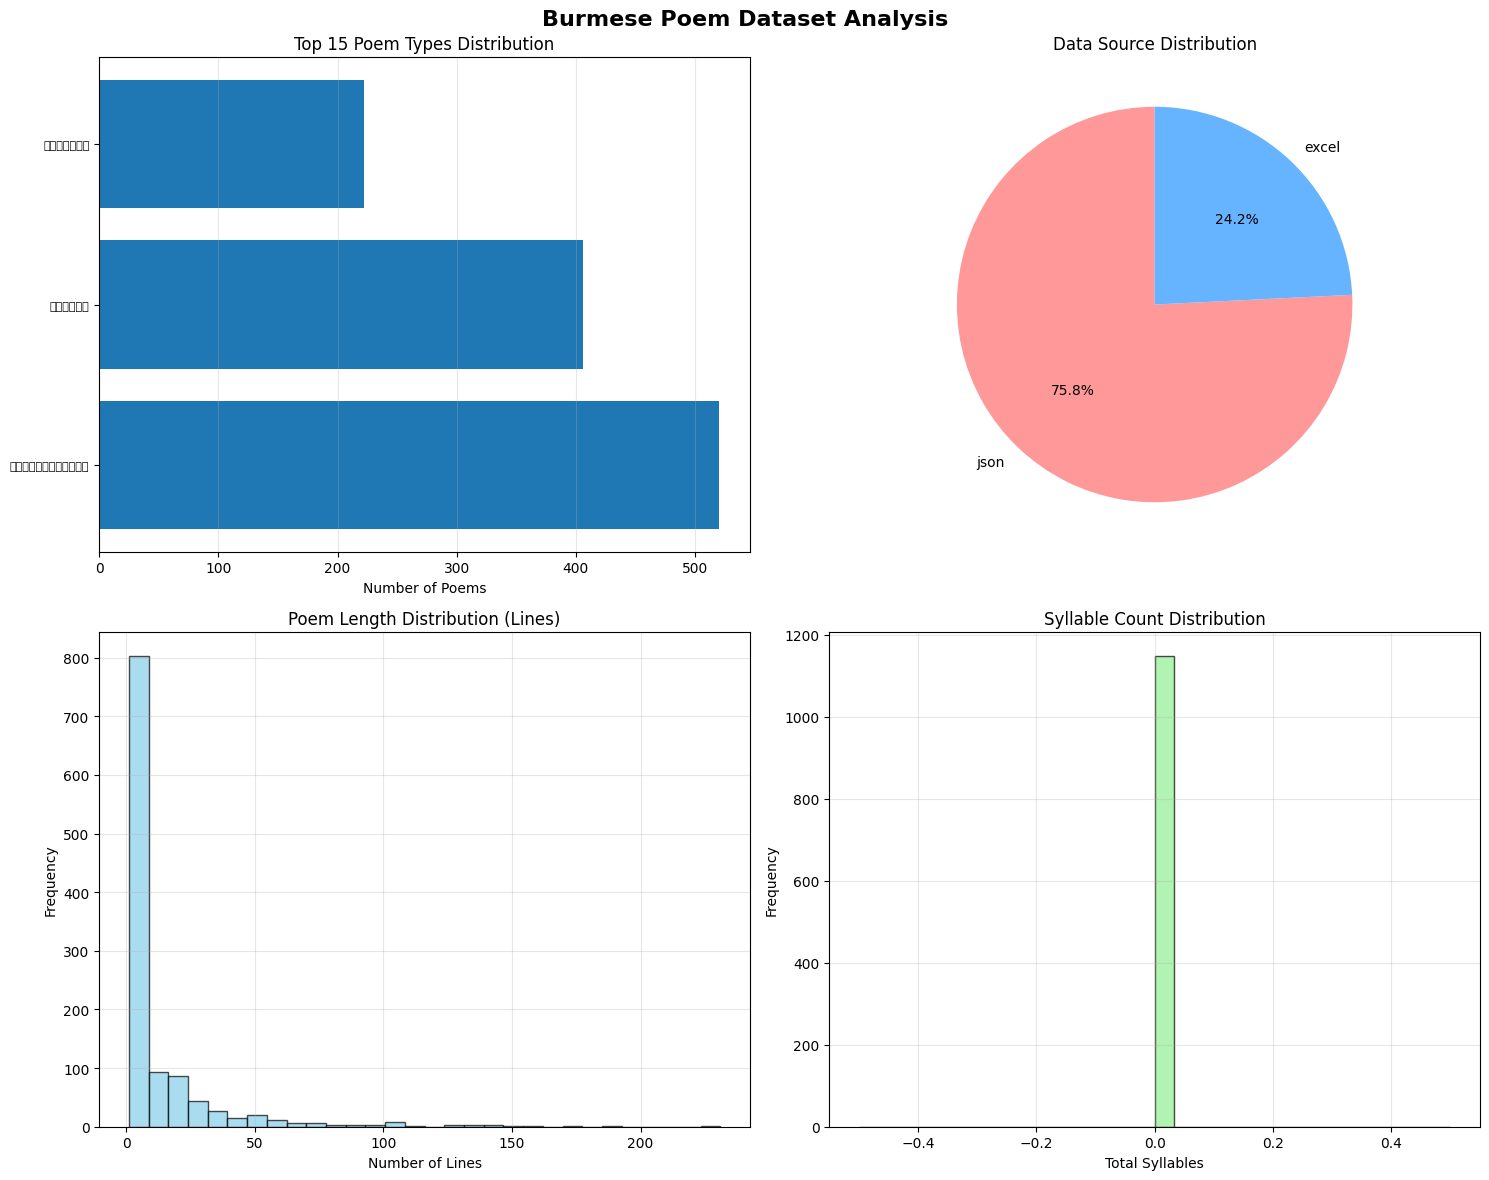


FEATURE PREPARATION FOR DEEP LEARNING
Training set size: 918
Test set size: 230
Classes: 3
Class names: ['ခေတ်ပေါ်ကဗျာ' 'လင်္ကာ' 'သီချင်း']

CREATING SEQUENCES FOR DEEP LEARNING
Vocabulary size: 108
Max sequence length: 500
Number of classes: 3
Training sequences shape: (918, 500)
Test sequences shape: (230, 500)

TRAINING DEEP LEARNING MODELS

1. Creating and training LSTM model...

=== Training LSTM ===
LSTM parameters: 137,603
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 730ms/step - accuracy: 0.4455 - loss: 1.0656 - val_accuracy: 0.4522 - val_loss: 1.0401 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 824ms/step - accuracy: 0.4510 - loss: 1.0454 - val_accuracy: 0.4826 - val_loss: 1.0186 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 850ms/step - accuracy: 0.4924 - loss: 1.0022 - val_accuracy: 0.4913 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 846ms/step - accuracy: 0.5763 - loss: 0.9467 - val_accuracy: 0.5

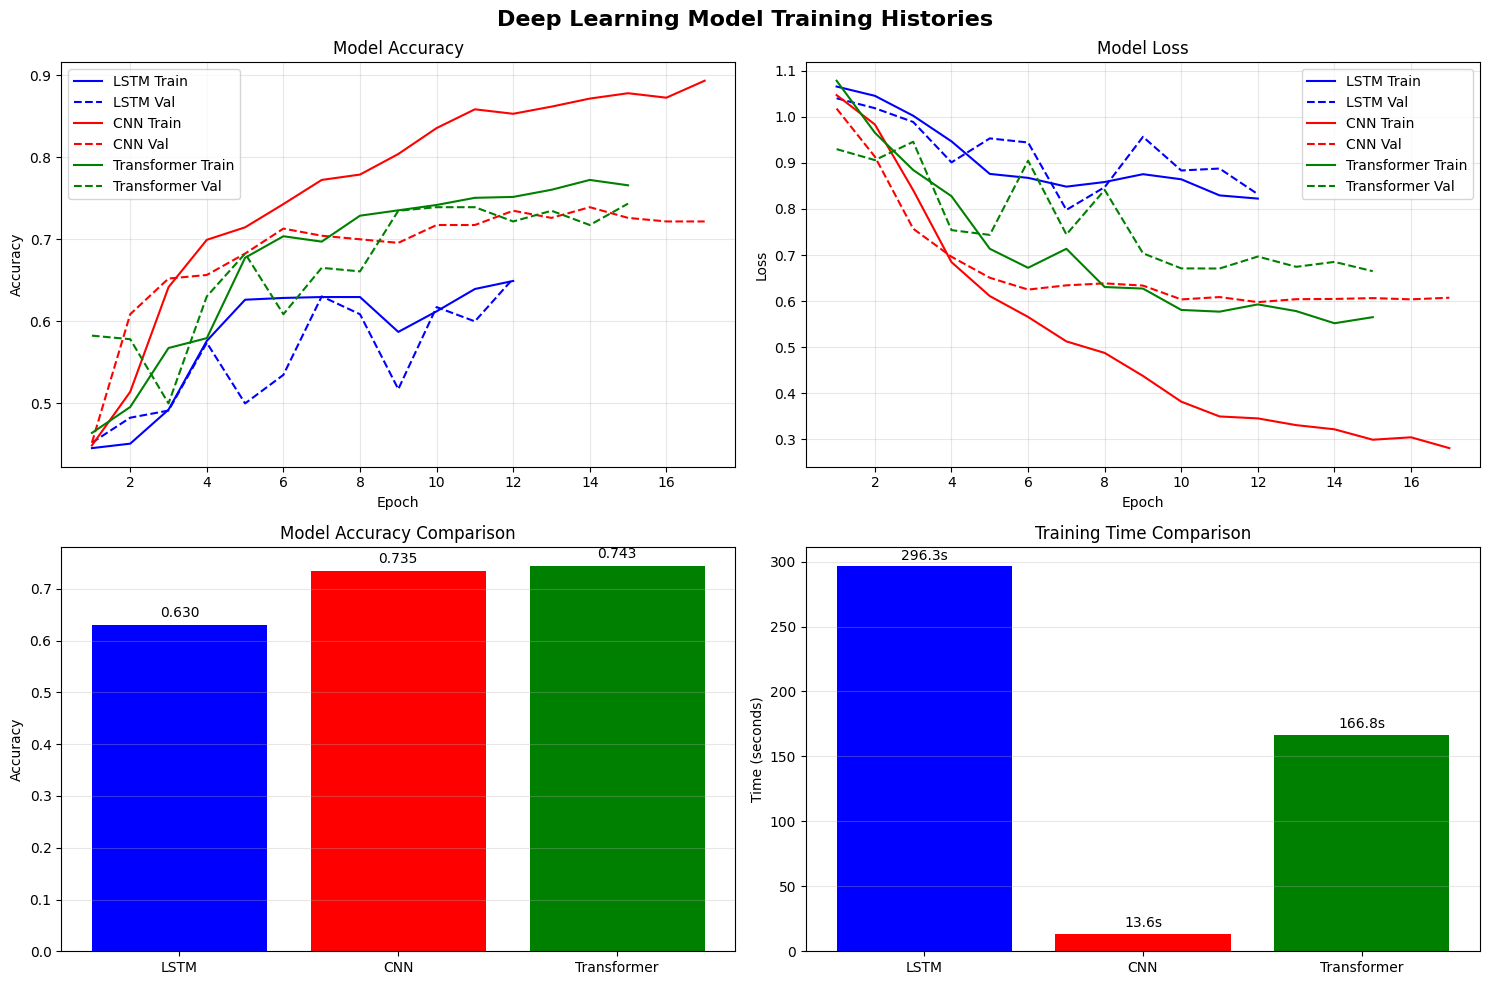

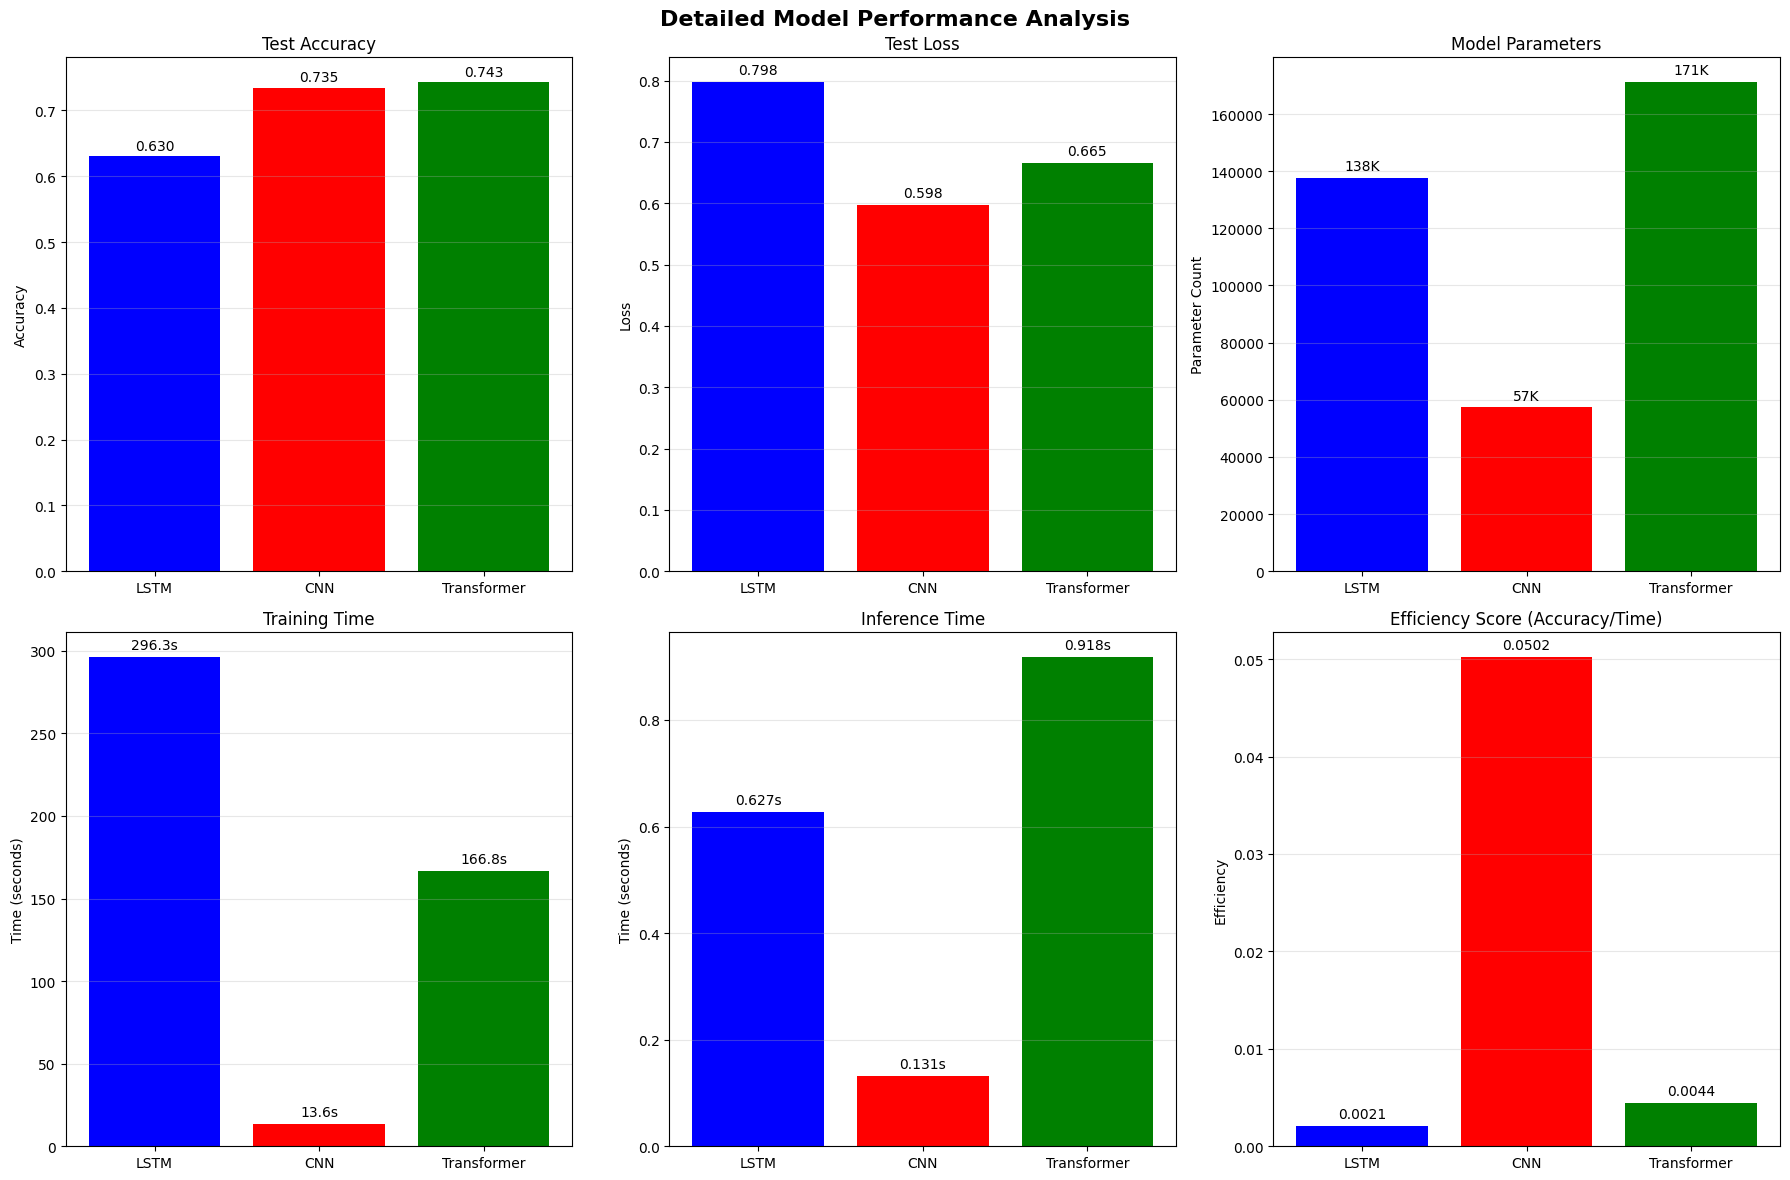


🎉 DEEP LEARNING PIPELINE COMPLETED SUCCESSFULLY!
✅ Best model: Transformer
✅ Accuracy: 0.7435
✅ Classes supported: 3
✅ Classifier ready for production!

🎯 Pipeline completed! Best model: Transformer with 0.7435 accuracy


In [ ]:
# Run the Complete Pipeline
pipeline_results = run_complete_deep_learning_pipeline(
    excel_path='Poem Excel files.xlsx',
    json_dir='PoemJsonFiles'
)

# Extract results
classifier = pipeline_results['classifier']
best_model_name = pipeline_results['best_model_name']
best_accuracy = pipeline_results['best_accuracy']

print(f"\n🎯 Pipeline completed! Best model: {best_model_name} with {best_accuracy:.4f} accuracy")


## 🧪 Test the Classifier

Now let's test our trained classifier with some example Burmese poems!


In [ ]:
# Test with Sample Poems

# Test Poem 1: Modern poem about civil war
sample_poem_1 = [
    "ခိုးသားထားပြ၊ ဟူတုံက၊ မုချကြောက်အပ်စွာ"
   
]


print("🔍 Testing Sample Poem 1:")
for i, line in enumerate(sample_poem_1, 1):
    print(f"  {i}. {line}")

# Simple prediction
predicted_type = classifier(sample_poem_1)
print(f"\n📊 Predicted poem type: {predicted_type}")

# Prediction with confidence
predicted_type, confidence = classifier(sample_poem_1, return_confidence=True)
print(f"📊 Predicted type: {predicted_type}")
print(f"📊 Confidence: {confidence:.4f}")

# Top 3 predictions
top_3 = classifier(sample_poem_1, top_k=3)
print(f"\n📊 Top 3 most likely poem types:")
for i, (poem_type, conf) in enumerate(top_3, 1):
    print(f"  {i}. {poem_type}: {conf:.4f}")


🔍 Testing Sample Poem 1:
  1. ခိုးသားထားပြ၊ ဟူတုံက၊ မုချကြောက်အပ်စွာ

📊 Predicted poem type: လင်္ကာ
📊 Predicted type: လင်္ကာ
📊 Confidence: 0.9243

📊 Top 3 most likely poem types:
  1. လင်္ကာ: 0.9243
  2. ခေတ်ပေါ်ကဗျာ: 0.0744
  3. သီချင်း: 0.0013


In [ ]:
# Test with Different Types of Poems

# Test Poem 2: Traditional four-line poem
sample_poem_2 = [
    "နံနက်မိုးပေါက်သံ ကြားရတယ်",
    "ငှက်သံများ သီဆိုနေတယ်",
    "စိတ်ကို အေးစေတယ်",
    "ငြိမ်းချမ်းတယ်"
]

print("\n" + "="*50)
print("🔍 Testing Sample Poem 2 (Traditional style):")
for i, line in enumerate(sample_poem_2, 1):
    print(f"  {i}. {line}")

predicted_type, confidence = classifier(sample_poem_2, return_confidence=True)
print(f"\n📊 Predicted type: {predicted_type}")
print(f"📊 Confidence: {confidence:.4f}")

# Test Poem 3: Short emotional poem
sample_poem_3 = [
    "မိုးရွာနေတဲ့ညမှာ",
    "စိတ်ညစ်တယ်", 
    "အိမ်ပြန်ချင်တယ်"
]

print("\n" + "="*50)
print("🔍 Testing Sample Poem 3 (Short emotional):")
for i, line in enumerate(sample_poem_3, 1):
    print(f"  {i}. {line}")

top_3 = classifier(sample_poem_3, top_k=3)
print(f"\n📊 Top 3 predictions:")
for i, (poem_type, conf) in enumerate(top_3, 1):
    print(f"  {i}. {poem_type}: {conf:.4f}")



🔍 Testing Sample Poem 2 (Traditional style):
  1. နံနက်မိုးပေါက်သံ ကြားရတယ်
  2. ငှက်သံများ သီဆိုနေတယ်
  3. စိတ်ကို အေးစေတယ်
  4. ငြိမ်းချမ်းတယ်

📊 Predicted type: လင်္ကာ
📊 Confidence: 0.8364

🔍 Testing Sample Poem 3 (Short emotional):
  1. မိုးရွာနေတဲ့ညမှာ
  2. စိတ်ညစ်တယ်
  3. အိမ်ပြန်ချင်တယ်

📊 Top 3 predictions:
  1. ခေတ်ပေါ်ကဗျာ: 0.8077
  2. လင်္ကာ: 0.1918
  3. သီချင်း: 0.0005


## 📈 Model Performance Summary

Let's examine the performance of all our deep learning models:


In [ ]:
# Model Performance Summary
models_results = pipeline_results['models_results']

print("🏆 DEEP LEARNING MODEL PERFORMANCE SUMMARY")
print("="*80)

performance_data = []
for model_name, result in models_results.items():
    performance_data.append({
        'Model': model_name,
        'Accuracy': f"{result['accuracy']:.4f}",
        'Loss': f"{result['loss']:.4f}",
        'Parameters': f"{result['param_count']:,}",
        'Training Time': f"{result['training_time']:.1f}s",
        'Inference Time': f"{result['inference_time']:.4f}s"
    })

performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string(index=False))

print(f"\n🥇 Best performing model: {pipeline_results['best_model_name']}")
print(f"🥇 Best accuracy: {pipeline_results['best_accuracy']:.4f}")
print(f"🥇 Supported classes: {len(pipeline_results['label_encoder'].classes_)}")

print(f"\n📋 Available poem types:")
for i, class_name in enumerate(pipeline_results['label_encoder'].classes_, 1):
    print(f"  {i:2d}. {class_name}")


🏆 DEEP LEARNING MODEL PERFORMANCE SUMMARY
      Model Accuracy   Loss Parameters Training Time Inference Time
       LSTM   0.6304 0.7980    137,603        296.3s        0.6266s
        CNN   0.7348 0.5979     57,315         13.6s        0.1313s
Transformer   0.7435 0.6650    171,267        166.8s        0.9185s

🥇 Best performing model: Transformer
🥇 Best accuracy: 0.7435
🥇 Supported classes: 3

📋 Available poem types:
   1. ခေတ်ပေါ်ကဗျာ
   2. လင်္ကာ
   3. သီချင်း


In [ ]:
# Save the Best Model and Components 

import pickle
import joblib

# Save the best model
best_model = pipeline_results['best_model']
tokenizer = pipeline_results['tokenizer']
label_encoder = pipeline_results['label_encoder']
max_length = pipeline_results['max_length']

# Save model (uncomment to save)
# best_model.save('best_burmese_poem_classifier.h5')
print(f"📁 Model can be saved as: best_burmese_poem_classifier_{pipeline_results['best_model_name'].lower()}.h5")

# Save tokenizer and other components (uncomment to save)
# with open('poem_classifier_components.pkl', 'wb') as f:
#     pickle.dump({
#         'tokenizer': tokenizer,
#         'label_encoder': label_encoder,
#         'max_length': max_length,
#         'model_name': pipeline_results['best_model_name']
#     }, f)

print(f"📁 Components can be saved as: poem_classifier_components.pkl")
print(f"📁 Best model: {pipeline_results['best_model_name']} with {pipeline_results['best_accuracy']:.4f} accuracy")

# Usage instructions
print(f"\n📖 To load the classifier later:")
print(f"```python")
print(f"import tensorflow as tf")
print(f"import pickle")
print(f"")
print(f"# Load model")
print(f"model = tf.keras.models.load_model('best_burmese_poem_classifier_{pipeline_results['best_model_name'].lower()}.h5')")
print(f"")
print(f"# Load components")
print(f"with open('poem_classifier_components.pkl', 'rb') as f:")
print(f"    components = pickle.load(f)")
print(f"")
print(f"# Create classifier")
print(f"classifier = create_production_classifier(")
print(f"    model, components['tokenizer'], components['max_length'], ")
print(f"    components['label_encoder'], components['model_name']")
print(f")")
print(f"```")


📁 Model can be saved as: best_burmese_poem_classifier_transformer.h5
📁 Components can be saved as: poem_classifier_components.pkl
📁 Best model: Transformer with 0.7435 accuracy

📖 To load the classifier later:
```python
import tensorflow as tf
import pickle

# Load model
model = tf.keras.models.load_model('best_burmese_poem_classifier_transformer.h5')

# Load components
with open('poem_classifier_components.pkl', 'rb') as f:
    components = pickle.load(f)

# Create classifier
classifier = create_production_classifier(
    model, components['tokenizer'], components['max_length'], 
    components['label_encoder'], components['model_name']
)
```
